### Importing Necessary Modules

In [1]:
import pandas as pd
import numpy as np
import math

from fastai.tabular.all import *
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

### Importing the Data

In [2]:
df_16_22 = pd.read_csv("data/train_v8.csv", 
                       index_col=0, 
                       dtype={'season':str,
                              'squad':str,
                              'comp':str})

In [3]:
# summary of fields
df_16_22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139511 entries, 0 to 139510
Data columns (total 59 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   player                                      139511 non-null  object 
 1   gw                                          139511 non-null  int64  
 2   position                                    139511 non-null  int64  
 3   minutes                                     139511 non-null  int64  
 4   team                                        139511 non-null  object 
 5   opponent_team                               139511 non-null  object 
 6   relative_market_value_team                  59488 non-null   float64
 7   relative_market_value_opponent_team         59465 non-null   float64
 8   was_home                                    139511 non-null  bool   
 9   total_points                                139511 non-null  int64  
 

In [4]:
def player_lag_features(df, features, lags):    
    df_new = df.copy()
    player_lag_vars = []
    
    # need minutes for per game stats, add to front of list
    features.insert(0, 'minutes')

    # calculate totals for each lag period
    for feature in features:
        for lag in lags:
            feature_name = feature + '_last_' + str(lag)
            minute_name = 'minutes_last_' + str(lag)
            
            if lag == 'all':
                df_new[feature_name] = df_new.groupby(['player'], group_keys=False)[feature].apply(lambda x: x.cumsum() - x)
            else: 
                df_new[feature_name] = df_new.groupby(['player'], group_keys=False)[feature].apply(lambda x: x.rolling(min_periods=1, 
                                                                                            window=lag+1).sum() - x)
            if feature != 'minutes':

                pg_feature_name = feature + '_pg_last_' + str(lag)
                player_lag_vars.append(pg_feature_name)
                
                df_new[pg_feature_name] = 90 * df_new[feature_name] / df_new[minute_name]
                
                # some cases of -1 points and 0 minutes cause -inf values
                # change these to NaN
                df_new[pg_feature_name] = df_new[pg_feature_name].replace([np.inf, -np.inf], np.nan)
            
            else: player_lag_vars.append(minute_name)
                
    return df_new, player_lag_vars

In [5]:
# team level lag features
def team_lag_features(df, features, lags):
    team_lag_vars = []
    df_new = df.copy()
    
    for feature in features:
        feature_team_name = feature + '_team'
        feature_conceded_team_name = feature_team_name + '_conceded'
        feature_team = (df.groupby(['team', 'season', 'gw',
                                   'kickoff_time', 'opponent_team'], group_keys=False)
                        [feature].sum().rename(feature_team_name).reset_index())
        
        # join back for points conceded
        feature_team = feature_team.merge(feature_team,
                           left_on=['team', 'season', 'gw',
                                    'kickoff_time', 'opponent_team'],
                           right_on=['opponent_team', 'season', 'gw',
                                     'kickoff_time', 'team'],
                           how='left',
                           suffixes = ('', '_conceded'))
                
        feature_team.drop(['team_conceded', 'opponent_team_conceded'], axis=1, inplace=True)
                
        for lag in lags:
            feature_name = feature + '_team_last_' + str(lag)
            feature_conceded_name = feature + '_team_conceded_last_' + str(lag)
            pg_feature_name = feature + '_team_pg_last_' + str(lag)
            pg_feature_conceded_name = feature + '_team_conceded_pg_last_' + str(lag)
            
            team_lag_vars.extend([pg_feature_name])#, pg_feature_conceded_name])
            
            if lag == 'all':
                feature_team[feature_name] = (feature_team.groupby('team', group_keys=False)[feature_team_name]
                                              .apply(lambda x: x.cumsum() - x))
                
                feature_team[feature_conceded_name] = (feature_team.groupby('team', group_keys=False)[feature_conceded_team_name]
                                              .apply(lambda x: x.cumsum() - x))
                
                feature_team[pg_feature_name] = (feature_team[feature_name]
                                                 / feature_team.groupby('team', group_keys=False).cumcount())
                
                feature_team[pg_feature_conceded_name] = (feature_team[feature_conceded_name]
                                                 / feature_team.groupby('team', group_keys=False).cumcount())
                
            else:
                feature_team[feature_name] = (feature_team.groupby('team', group_keys=False)[feature_team_name]
                                              .apply(lambda x: x.rolling(min_periods=1, 
                                                                         window=lag + 1).sum() - x))
                
                feature_team[feature_conceded_name] = (feature_team.groupby('team', group_keys=False)[feature_conceded_team_name]
                                              .apply(lambda x: x.rolling(min_periods=1, 
                                                                         window=lag + 1).sum() - x))
                
                feature_team[pg_feature_name] = (feature_team[feature_name] / 
                                                 feature_team.groupby('team', group_keys=False)[feature_team_name]
                                                 .apply(lambda x: x.rolling(min_periods=1, 
                                                                            window=lag + 1).count() - 1))
                
                feature_team[pg_feature_conceded_name] = (feature_team[feature_conceded_name] / 
                                                 feature_team.groupby('team', group_keys=False)[feature_conceded_name]
                                                 .apply(lambda x: x.rolling(min_periods=1, 
                                                                            window=lag + 1).count() - 1))
        
        df_new = df_new.merge(feature_team, 
                          on=['team', 'season', 'gw', 'kickoff_time', 'opponent_team'], 
                          how='left')
        
        df_new = df_new.merge(feature_team,
                 left_on=['team', 'season', 'gw', 'kickoff_time', 'opponent_team'],
                 right_on=['opponent_team', 'season', 'gw', 'kickoff_time', 'team'],
                 how='left',
                 suffixes = ('', '_opponent'))
        
        df_new.drop(['team_opponent', 'opponent_team_opponent'], axis=1, inplace=True)
        
    team_lag_vars = team_lag_vars + [team_lag_var + '_opponent' for team_lag_var in team_lag_vars]  

    return df_new, team_lag_vars

In [6]:
# create some lag features
lag_train_df, team_lag_vars = team_lag_features(df_16_22, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])


In [7]:
lag_train_df.shape

(139511, 140)

In [8]:
lag_train_df[['season',
          'gw', 
          'minutes', 
          'minutes_last_1',
          'total_points',
          'total_points_last_1', 
          'total_points_last_2', 
          'total_points_last_3', 
          'total_points_last_5', 
          'total_points_last_all', 
          'total_points_team_last_all']][lag_train_df['player'] == 'Mohamed Salah'].tail(10)


,season,gw,minutes,minutes_last_1,total_points,total_points_last_1,total_points_last_2,total_points_last_3,total_points_last_5,total_points_last_all,total_points_team_last_all
132953,2122,29,64,78.0,9,3.0,21.0,31.0,35.0,1238,11712
132954,2122,29,34,64.0,1,9.0,12.0,30.0,43.0,1247,11785
134086,2122,31,68,34.0,3,1.0,10.0,13.0,41.0,1248,11853
134828,2122,32,90,68.0,5,3.0,4.0,13.0,34.0,1251,11925
135644,2122,33,90,90.0,19,5.0,8.0,9.0,21.0,1256,11957
136452,2122,34,90,90.0,6,19.0,24.0,27.0,37.0,1275,12045
137203,2122,35,21,90.0,1,6.0,25.0,30.0,34.0,1281,12114
137750,2122,36,90,21.0,2,1.0,7.0,26.0,34.0,1282,12175
137751,2122,36,18,90.0,1,2.0,3.0,9.0,33.0,1284,12210
139239,2122,37,0,18.0,0,1.0,3.0,4.0,29.0,1285,12258


In [9]:
lag_train_df['season'].unique()

array(['1617', '1718', '1819', '1920', '2021', '2122'], dtype=object)

# Create Validation Model

In [10]:

def validation_gw_idx(df, season, gw, length):
    
    valid_start = df[(df['gw'] == gw) & (df['season'] == season)].index.min()
    valid_end = df[(df['gw'] == min(gw+length-1, 38)) & (df['season'] == season)].index.max()

    print(f"range for season {season}, start: {valid_start}, end: {valid_end}")

    return (valid_start, valid_end)

def simple_model(df, valid_season, valid_gw, valid_len):
    # get our validation index points
    valid_start, valid_end = validation_gw_idx(df, valid_season, valid_gw, valid_len)
    
    # indexes for training and validation sets
    train_idx = range(valid_start)
    valid_idx = range(valid_start, valid_end + 1)    
    
    # create training and validation dataframes
    # the validation set has no features
    train = df.iloc[train_idx]
    valid = df[['player', 'gw', 'season', 'minutes', 'total_points']].iloc[valid_idx]
    
    season_point = valid['season'].iloc[0]
    gw_point = valid['gw'].iloc[0]
    
    # get player total per game average at validation point
    player_points_pg = df[(df['season'] == season_point) & 
                          (df['gw'] == gw_point)][['player', 'total_points_pg_last_all', 'minutes_last_1']]
    
    # sometimes players play twice in a gw, we want the values at the first game
    player_points_pg =  player_points_pg.groupby('player').first().reset_index()
    
    # set the player per game averages and most recent minutes for all games in the validation set 
    pred_df = valid.merge(player_points_pg, on='player', how='left')
    
    # we only want to see performance for rows with minutes>0
    # not relevant if we are including minutes in the model
    pred_df = pred_df[pred_df['minutes'] > 0]
    
    # use the average across all players-minutes for any nulls (from 00_fpl_features) 
    # i.e. where player does not have any history
    pred_df['total_points_pg_last_all'].fillna(3.74, inplace=True)
    pred_df['minutes_last_1'].fillna(0, inplace=True)
    preds = pred_df['total_points_pg_last_all'] * pred_df['minutes_last_1'] / 90
    targs = pred_df['total_points']
    
    return preds, targs


In [11]:
# rmse for predictions versus actuals
def r_mse(pred,y): 
    return round(math.sqrt(((pred-y)**2).mean()), 6)

# mse for predictions versus actuals
def mae(pred, y): 
     return round(abs(pred-y).mean(), 6)


# Neural Network Model

In [15]:
# set validaton point/length and categorical/continuous variables
valid_season = '2122'
valid_gw = 20
valid_len = 6
cat_vars = ['gw', 'season', 'position', 'team', 'opponent_team', 'was_home']
cont_vars = ['minutes']
dep_var = ['total_points']

# we want to set gw and season as ordered categorical variables
# need lists with ordered categories
ordered_gws = list(range(1,39))
ordered_seasons = ['1617', '1718', '1819', '1920', '2021', '2122']

In [16]:
# set as categories with correct order 
lag_train_df['gw'] = lag_train_df['gw'].astype('category')
lag_train_df['season'] = lag_train_df['season'].astype('category')

lag_train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
lag_train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)

# dependent variable needs to be float
lag_train_df['total_points'] = lag_train_df['total_points'].astype('float64')

/var/folders/dw/ytcbqs0s6cn1cf67hn7gczph0000gn/T/ipykernel_72847/3029120136.py:5: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  lag_train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
/var/folders/dw/ytcbqs0s6cn1cf67hn7gczph0000gn/T/ipykernel_72847/3029120136.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  lag_train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)


In [17]:
def create_lag_train(df, cat_vars, cont_vars, player_lag_vars, team_lag_vars, dep_var, valid_season, valid_gw, valid_len):

    # get all the lag data for the current season up to the first validation gameweek
    player_lag_vals = df[(df['season'] == valid_season) & 
                         (df['gw'] >= valid_gw)][['player', 'kickoff_time'] + player_lag_vars]
    
    team_lag_vals = df[(df['season'] == valid_season) & 
                       (df['gw'] >= valid_gw)][['team', 'kickoff_time'] + 
                                               [x for x in team_lag_vars if "opponent" not in x]].drop_duplicates()
                                               
    opponent_team_lag_vals = df[(df['season'] == valid_season) & 
                                (df['gw'] >= valid_gw)][['opponent_team', 'kickoff_time'] + 
                                                        [x for x in team_lag_vars if "opponent" in x]].drop_duplicates()
    
    
    # get the last available lag data for each player
    # for most it will be the first validation week
    # but sometimes teams have blank gameweeks
    # in these cases it will be the previous gameweek
    player_lag_vals = player_lag_vals[player_lag_vals['kickoff_time'] == 
                                      player_lag_vals.groupby('player')['kickoff_time'].transform('min')]
    team_lag_vals = team_lag_vals[team_lag_vals['kickoff_time'] == 
                                  team_lag_vals.groupby('team')['kickoff_time'].transform('min')]
    opponent_team_lag_vals = opponent_team_lag_vals[opponent_team_lag_vals['kickoff_time'] == 
                                                    opponent_team_lag_vals.groupby('opponent_team')['kickoff_time'].transform('min')]
                                                                    
    player_lag_vals = player_lag_vals.drop('kickoff_time', axis=1)
    team_lag_vals = team_lag_vals.drop('kickoff_time', axis=1)
    opponent_team_lag_vals = opponent_team_lag_vals.drop('kickoff_time', axis=1)
    
    
    # get the validation start and end indexes
    valid_start, valid_end = validation_gw_idx(df, valid_season, valid_gw, valid_len)
    train_idx = range(valid_start)
    valid_idx = range(valid_start, valid_end + 1)    

    # split out train and validation sets
    # do not include lag vars in validation set
    cat_vars = list(set(['opponent_team', 'team', 'player'] + cat_vars))
    
    train = df[cat_vars + cont_vars + 
               player_lag_vars + team_lag_vars + 
               dep_var].iloc[train_idx]
    valid = df[cat_vars + cont_vars + dep_var].iloc[valid_idx]

    # add in lag vars
    # will be the same for all validation gameweeks
    valid = valid.merge(player_lag_vals, on='player', how='left')
    valid = valid.merge(team_lag_vals, on='team', how='left')
    valid = valid.merge(opponent_team_lag_vals, on='opponent_team', how='left')
        
    # concatenate train and test again
    lag_train_df = pd.concat([train, valid], sort=True).reset_index(drop=True)

    return lag_train_df, train_idx, valid_idx

train_valid_df, train_idx, valid_idx = create_lag_train(lag_train_df, 
                                                      cat_vars, cont_vars, 
                                                      player_lag_vars, team_lag_vars, dep_var,
                                                      valid_season, valid_gw, valid_len)

train_valid_df[player_lag_vars + team_lag_vars] = train_valid_df[player_lag_vars + team_lag_vars].fillna(0)

range for season 2122, start: 125645, end: 129658


In [18]:
# take a look at the dataframe
train_valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129659 entries, 0 to 129658
Data columns (total 37 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   gw                                      129659 non-null  category
 1   minutes                                 129659 non-null  int64   
 2   minutes_last_1                          129659 non-null  float64 
 3   minutes_last_10                         129659 non-null  float64 
 4   minutes_last_2                          129659 non-null  float64 
 5   minutes_last_3                          129659 non-null  float64 
 6   minutes_last_4                          129659 non-null  float64 
 7   minutes_last_5                          129659 non-null  float64 
 8   minutes_last_all                        129659 non-null  int64   
 9   opponent_team                           129659 non-null  object  
 10  player                          

In [20]:
train_valid_df = pd.concat([train_valid_df.loc[train_idx],
                            train_valid_df.loc[valid_idx][train_valid_df.loc[valid_idx]['minutes'] > 0]],
                           ignore_index=True)
valid_idx = range(valid_idx[0], train_valid_df.index.max() + 1)
splits = (list(train_idx), list(valid_idx))
valid_idx

range(125645, 127236)

In [21]:
train_valid_df[cat_vars + ['player']].nunique()


gw                 38
season              6
position            4
team               31
opponent_team      31
was_home            2
player           1692
dtype: int64

In [22]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
to_nn = TabularPandas(train_valid_df, 
                      [Categorify, Normalize], 
                      cat_vars + ['player'], 
                      cont_vars, #+ player_lag_vars + team_lag_vars,
                      splits=splits, y_names=dep_var)


In [23]:
dls = to_nn.dataloaders()
dls.show_batch()

,gw,season,position,team,opponent_team,was_home,player,minutes,total_points
0,9,2021,2,Everton,Fulham,False,Seamus Coleman,-7.269295e-07,0.0
1,34,2021,4,Sheffield United,Tottenham Hotspur,False,Oliver McBurnie,-7.269295e-07,0.0
2,27,1920,1,Brighton and Hove Albion,Sheffield United,False,Mathew Ryan,9.000000e+01,2.0
3,7,1819,3,Brighton and Hove Albion,Manchester City,False,Beram Kayal,9.000000e+01,2.0
4,22,1617,3,Bournemouth,Watford,True,Dan Gosling,-7.269295e-07,0.0
5,23,1617,3,West Bromwich Albion,Middlesbrough,False,Jonathan Leko,-7.269295e-07,0.0
6,5,2021,2,Manchester United,Newcastle United,False,Luke Shaw,9.000000e+01,0.0
7,31,2021,3,Brighton and Hove Albion,Everton,True,Aaron Mooy,-7.269295e-07,0.0
8,19,1920,3,Aston Villa,Norwich,True,Henri Lansbury,9.999993e-01,1.0
9,38,1920,2,Everton,Bournemouth,True,Rhu-endly Martina,-7.269295e-07,0.0


In [24]:
# set range of predictions - minimum to current max
max_y = np.max(lag_train_df['total_points'])
min_y = np.min(lag_train_df['total_points'])
y_range = (-1, max_y)

In [30]:
config = tabular_config(ps=[0.001,0.01],
                        embed_p=0.04)
learn = tabular_learner(dls, 
                        y_range=y_range, 
                        layers=[500,250],
                        n_out=1,
                        loss_func=F.mse_loss,
                        metrics=rmse,
                        config=config)

SuggestedLRs(valley=0.002511886414140463)

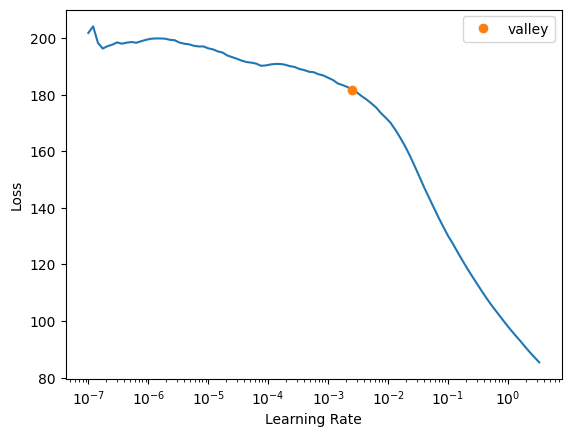

In [31]:
learn.lr_find()

In [32]:
learn.fit_one_cycle(5, 5e-3, wd=0.2)
learn.fit_one_cycle(5, 5e-3, wd=0.2)


epoch,train_loss,valid_loss,_rmse,time
0,3.941984,7.579631,2.753113,00:40
1,3.752684,8.093615,2.844928,00:38
2,3.461777,7.787339,2.790580,00:38
3,3.575195,7.422688,2.724461,00:38
4,3.349705,7.387857,2.718061,00:38


epoch,train_loss,valid_loss,_rmse,time
0,3.622970,7.783342,2.789864,00:39
1,3.489794,7.679892,2.771262,00:38
2,2.922496,7.318524,2.705277,00:38
3,3.128485,7.373337,2.715389,00:39
4,3.166752,7.290525,2.700097,00:39


In [33]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

2.700097

In [34]:
def mae_tensor(pred,y): return round((abs(pred-y)).mean().item(), 6)
mae_tensor(preds,targs)

1.885129

In [37]:
def nn_season(df, valid_season='1920'):

    # empty list for scores
    scores = []
    valid_len = 6

    # set limits
    max_y = np.max(df['total_points'])
    min_y = np.min(df['total_points'])
    y_range = (-1, max_y)

    for valid_gw in range(1,34): 

        train_valid_df, train_idx, valid_idx = create_lag_train(df, cat_vars, cont_vars, 
                                                        player_lag_vars, team_lag_vars, dep_var,
                                                        valid_season, valid_gw, valid_len)

        X, y = train_valid_df[cat_vars + cont_vars + player_lag_vars + team_lag_vars].copy(), train_valid_df[dep_var].copy()

        # need to remove 0 minute rows from the validation set
        train_valid_df = pd.concat([train_valid_df.loc[train_idx],
                                    train_valid_df.loc[valid_idx][train_valid_df.loc[valid_idx]['minutes'] > 0]],
                                   ignore_index=True)
        
        # and redo the valid indexes
        valid_idx = range(valid_idx[0], train_valid_df.index.max() + 1)
        
        # create train/valid splits
        splits = (list(train_idx), list(valid_idx))

        # processors - categorify categorical variables and normalize continuous variables
        # fill missing not used because new teams are almost certainly well below the league average
        procs=[Categorify, Normalize]
        to_nn = TabularPandas(train_valid_df, procs, cat_vars + ['player'], cont_vars, #+ player_lag_vars + team_lag_vars,
                              splits=splits, y_names=dep_var)

        dls = to_nn.dataloaders()

#         learn = tabular_learner(dls, y_range=y_range, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,
#                             n_out=1, loss_func=F.mse_loss, metrics=rmse)
        config = tabular_config(ps=[0.001,0.01],
                                embed_p=0.04)
        
        learn = tabular_learner(dls,
                                y_range=y_range, 
                                layers=[500,250],
                                n_out=1, 
                                loss_func=F.mse_loss, 
                                metrics=rmse,
                                config=config)


        # seems to work ok without the lag vars
        with learn.no_bar() and learn.no_logging():
#             learn.fit_one_cycle(7, 1e-2, wd=0.2, verbose=False)
            learn.fit_one_cycle(5, 5e-3, wd=0.2)
            learn.fit_one_cycle(5, 5e-3, wd=0.2)

        preds,targs = learn.get_preds()
        gw_mae = mae_tensor(preds,targs)

        print("GW%d MAE: %f" % (valid_gw, gw_mae))

        scores.append(gw_mae)
        
    return scores

In [38]:
scores = nn_season(lag_train_df)

range for season 1920, start: 67936, end: 71131


GW1 MAE: 1.977333
range for season 1920, start: 68462, end: 71677


GW2 MAE: 1.952564
range for season 1920, start: 68991, end: 72228


GW3 MAE: 2.025256
range for season 1920, start: 69520, end: 72783


GW4 MAE: 1.909957
range for season 1920, start: 70052, end: 73339


GW5 MAE: 1.956367
range for season 1920, start: 70591, end: 73896


GW6 MAE: 2.000149
range for season 1920, start: 71132, end: 74455


GW7 MAE: 1.931687
range for season 1920, start: 71678, end: 75015


GW8 MAE: 1.931494
range for season 1920, start: 72229, end: 75579


GW9 MAE: 1.904015
range for season 1920, start: 72784, end: 76144


GW10 MAE: 1.930343
range for season 1920, start: 73340, end: 76713


GW11 MAE: 1.890994
range for season 1920, start: 73897, end: 77289


GW12 MAE: 1.929717
range for season 1920, start: 74456, end: 77809


GW13 MAE: 1.966239
range for season 1920, start: 75016, end: 78389


GW14 MAE: 1.961894
range for season 1920, start: 75580, end: 78973


GW15 MAE: 1.885249
range for season 1920, start: 76145, end: 79559


GW16 MAE: 1.941676
range for season 1920, start: 76714, end: 80156


GW17 MAE: 1.886216
range for season 1920, start: 77290, end: 80762


GW18 MAE: 1.861993
range for season 1920, start: 77810, end: 81434


GW19 MAE: 1.888127
range for season 1920, start: 78390, end: 82053


GW20 MAE: 1.881373
range for season 1920, start: 78974, end: 82676


GW21 MAE: 1.912392
range for season 1920, start: 79560, end: 83300


GW22 MAE: 1.943825
range for season 1920, start: 80157, end: 83804


GW23 MAE: 1.911636
range for season 1920, start: 80763, end: 84432


GW24 MAE: 1.946812
range for season 1920, start: 81435, end: 85193


GW25 MAE: 1.903773
range for season 1920, start: 82054, end: 85837


GW26 MAE: 1.840922
range for season 1920, start: 82677, end: 86485


GW27 MAE: 1.844449
range for season 1920, start: 83301, end: 87137


GW28 MAE: 1.817681
range for season 1920, start: 83805, end: 87790


GW29 MAE: 1.815405
range for season 1920, start: 84433, end: 88444


GW30 MAE: 1.876727
range for season 1920, start: 85194, end: 89105


GW31 MAE: 1.816576
range for season 1920, start: 85838, end: 89770


GW32 MAE: 1.855501
range for season 1920, start: 86486, end: 90436


GW33 MAE: 1.810686


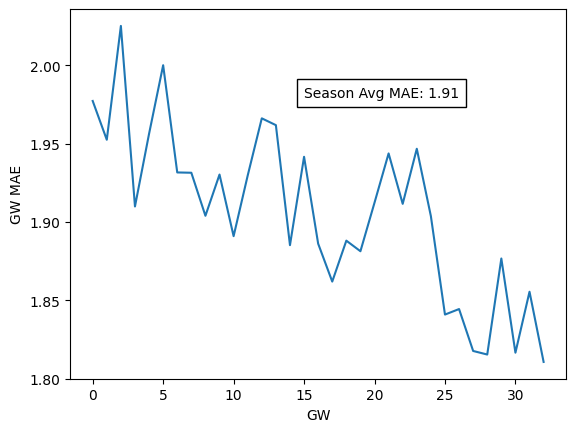

In [39]:
plt.plot(scores)
plt.ylabel('GW MAE')
plt.xlabel('GW')
plt.text(15, 1.98, 'Season Avg MAE: %.2f' % np.mean(scores), bbox={'facecolor':'white', 'alpha':1, 'pad':5})
plt.show()

In [40]:
learn.export('model1.pkl')

In [42]:
learn.layers

Sequential(
  (0): LinBnDrop(
    (0): Linear(in_features=150, out_features=500, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
  )
  (1): LinBnDrop(
    (0): Linear(in_features=500, out_features=250, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.01, inplace=False)
  )
  (2): LinBnDrop(
    (0): Linear(in_features=250, out_features=1, bias=True)
  )
  (3): fastai.layers.SigmoidRange(low=-1, high=29.0)
)

In [50]:
lag_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139511 entries, 0 to 139510
Columns: 140 entries, player to total_points_pg_last_10
dtypes: bool(1), category(2), float64(105), int64(25), object(7)
memory usage: 147.3+ MB


In [44]:

train_valid_df, train_idx, valid_idx = create_lag_train(lag_train_df, cat_vars, cont_vars, 
                                                player_lag_vars, team_lag_vars, dep_var,
                                                valid_season, valid_gw, valid_len)

X, y = train_valid_df[cat_vars + cont_vars + player_lag_vars + team_lag_vars].copy(), train_valid_df[dep_var].copy()

# need to remove 0 minute rows from the validation set
train_valid_df = pd.concat([train_valid_df.loc[train_idx],
                            train_valid_df.loc[valid_idx][train_valid_df.loc[valid_idx]['minutes'] > 0]],
                            ignore_index=True)

# and redo the valid indexes
valid_idx = range(valid_idx[0], train_valid_df.index.max() + 1)

# create train/valid splits
splits = (list(train_idx), list(valid_idx))

# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]
to_nn = TabularPandas(train_valid_df, procs, cat_vars + ['player'], cont_vars, #+ player_lag_vars + team_lag_vars,
                        splits=splits, y_names=dep_var)

dls = to_nn.dataloaders()

#         learn = tabular_learner(dls, y_range=y_range, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,
#                             n_out=1, loss_func=F.mse_loss, metrics=rmse)
config = tabular_config(ps=[0.001,0.01],
                        embed_p=0.04)

learn = tabular_learner(dls,
                        y_range=y_range, 
                        layers=[500,250],
                        n_out=1, 
                        loss_func=F.mse_loss, 
                        metrics=rmse,
                        config=config)


# seems to work ok without the lag vars
# with learn.no_bar() and learn.no_logging():
# #             learn.fit_one_cycle(7, 1e-2, wd=0.2, verbose=False)
#     learn.fit_one_cycle(5, 5e-3, wd=0.2)
learn.fit_one_cycle(5, 5e-3, wd=0.2)

preds,targs = learn.get_preds()

preds

range for season 2122, start: 125645, end: 129658


epoch,train_loss,valid_loss,_rmse,time
0,3.850408,9.172385,3.028594,00:46
1,3.542525,7.640720,2.764185,00:44
2,3.549941,7.611843,2.758957,00:44
3,3.135491,7.749574,2.783806,00:44
4,3.118179,7.669131,2.769320,00:43


tensor([[2.1044],
        [4.6362],
        [2.7265],
        ...,
        [1.0736],
        [2.3567],
        [3.7545]])

In [59]:
pd.DataFrame(preds).to_csv("data/fpl_player_data.csv", index=False)